In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import get_data
import get_bestfit
import seawater as sw
from scipy import stats
from scipy import odr

In [2]:
def find_outliers(beta,x,y,dx,dy,inds=None):
    if len(beta)==1:
        beta = [1,beta[0]]
    xhat = (dy**2*x + dx**2*beta[0]*(y-beta[1]))/(dy**2+(dx*beta[0])**2)
    error = np.sqrt((xhat**2-2*xhat*x + x**2)/dx**2 + ((beta[0]*xhat)**2+2*beta[0]*xhat*(beta[1]-y)+(beta[1]-y)**2)/dy**2)
    error[x>xhat] *= -1
    if inds is None:
        outliers = np.abs(error/np.std(error))>3
    else:
        outliers = np.abs(error/np.std(error[inds]))>3
    return outliers

def offset_func(beta,x):
    return x+beta
offset_model = odr.Model(offset_func)

In [3]:
ylabel = 'FLBB (SR)'
xlabel = 'FLBB (LF)'

In [4]:
data_folder = '/Users/zerickso/Research/EXPORTS/Pacific/Data/SeaBASS'
folder = '%s/CTD_Ride'%data_folder
data1_loc = get_data.get_FLBB_SR(folder,get_data=False,verbose=True)
file = '%s/LagrangianFloat/EXPORTS-EXPORTSNP_bb_Seabird_float_20180814_R1.sb'%data_folder
data2_loc = get_data.get_FLBB_LF(file,get_data=False,verbose=True)

Output is time, lat, lon, station
Output is time, lat, lon


In [5]:
inds1,inds2,dist,dtime = get_bestfit.find_nearby((data1_loc[0],data2_loc[0]),(data1_loc[1],data2_loc[1]),(data1_loc[2],data2_loc[2]),6/24,5,return_distances=True)
data1 = get_data.get_FLBB_SR(folder,get_dives=data1_loc[3][inds1],verbose=True)
data2 = get_data.get_FLBB_LF(file,get_dives=inds2,verbose=True)
print('%d matches found'%len(inds1))

Output is time, lat, lon, station, T, S, z, VSF
Output is time, lat, lon, T, S, z, VSF
6 matches found


In [6]:
filtered_data1 = [get_data.median_filter(VSF,depth=z) for VSF,z in zip(data1[7],data1[6])]
filtered_data2 = [get_data.median_filter(VSF,depth=z) for VSF,z in zip(data2[6],data2[5])]

filtered_VSF1 = [f[0] for f in filtered_data1]
filtered_VSF2 = [f[0] for f in filtered_data2]
filtered_dep1 = [f[2] for f in filtered_data1]
filtered_dep2 = [f[2] for f in filtered_data2]

dens1 = sw.pden(data1[5],data1[4],sw.pres(data1[6],lat=50.5))
dens2 = sw.pden(data2[4],data2[3],sw.pres(data2[5],lat=50.5))

filtered_dens1 = [np.interp(fdep,dep[np.isfinite(dens)],dens[np.isfinite(dens)]) 
                  for fdep,dep,dens in zip(filtered_dep1,data1[6],dens1)]
filtered_dens2 = [np.interp(fdep,dep[np.isfinite(dens)],dens[np.isfinite(dens)]) 
                  for fdep,dep,dens in zip(filtered_dep2,data2[5],dens2)]
filtered_salt1 = [np.interp(fdep,dep[np.isfinite(dens)],salt[np.isfinite(dens)]) 
                  for fdep,dep,dens,salt in zip(filtered_dep1,data1[6],dens1,data1[5])]
filtered_salt2 = [np.interp(fdep,dep[np.isfinite(dens)],salt[np.isfinite(dens)]) 
                  for fdep,dep,dens,salt in zip(filtered_dep2,data2[5],dens2,data2[4])]
filtered_temp1 = [np.interp(fdep,dep[np.isfinite(dens)],temp[np.isfinite(dens)]) 
                  for fdep,dep,dens,temp in zip(filtered_dep1,data1[6],dens1,data1[4])]
filtered_temp2 = [np.interp(fdep,dep[np.isfinite(dens)],temp[np.isfinite(dens)]) 
                  for fdep,dep,dens,temp in zip(filtered_dep2,data2[5],dens2,data2[3])]



In [7]:
dpyc = 0.1
interp_dens = np.arange(1024.05,1026.4,dpyc)
n = len(filtered_VSF1)
VSF_interp1,VSF_interp1_sd = get_bestfit.interpolate_data(filtered_VSF1,filtered_dens1,np.meshgrid(interp_dens,np.arange(n))[0],ddep=dpyc/2,return_uncert=True,minimum_uncert=1.11e-6)
dep_interp1 = get_bestfit.interpolate_data(filtered_dep1,filtered_dens1,np.meshgrid(interp_dens,np.arange(n))[0])
T_interp1 = get_bestfit.interpolate_data(filtered_temp1,filtered_dens1,np.meshgrid(interp_dens,np.arange(n))[0])
S_interp1 = get_bestfit.interpolate_data(filtered_salt1,filtered_dens1,np.meshgrid(interp_dens,np.arange(n))[0])

VSF_interp2,VSF_interp2_sd = get_bestfit.interpolate_data(filtered_VSF2,filtered_dens2,np.meshgrid(interp_dens,np.arange(n))[0],ddep=dpyc/2,return_uncert=True,minimum_uncert=6.51e-6)
dep_interp2 = get_bestfit.interpolate_data(filtered_dep2,filtered_dens2,np.meshgrid(interp_dens,np.arange(n))[0])
T_interp2 = get_bestfit.interpolate_data(filtered_temp2,filtered_dens2,np.meshgrid(interp_dens,np.arange(n))[0])
S_interp2 = get_bestfit.interpolate_data(filtered_salt2,filtered_dens2,np.meshgrid(interp_dens,np.arange(n))[0])

dsalt = np.abs(S_interp1-S_interp2).ravel()
dtemp = np.abs(T_interp1-T_interp2).ravel()

/Users/zerickso/Documents/Papers_in_progress/Erickson_etal_El20/Code/get_bestfit.py:66: RuntimeWarning: Mean of empty slice
  interp_data = np.array([[avefunc(dat[np.abs(dat_z-z)<ddep]) for z in zz] for zz,dat_z,dat in zip(deps,data_dep,data)])
/Users/zerickso/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/zerickso/Documents/Papers_in_progress/Erickson_etal_El20/Code/get_bestfit.py:70: RuntimeWarning: invalid value encountered in less
  interp_uncert[interp_uncert<minimum_uncert] = minimum_uncert


In [8]:
y = VSF_interp1.ravel()*2*np.pi*1.14
dy = VSF_interp1_sd.ravel()*2*np.pi*1.14
x = VSF_interp2.ravel()*2*np.pi*1.14
dx = VSF_interp2_sd.ravel()*2*np.pi*1.14

inds = np.isfinite(x*y*dx*dy) & (dsalt<0.01) & (dtemp<0.05)

/Users/zerickso/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [9]:
# first find outliers for both the line and offset
data = odr.RealData(x[inds], y[inds], sx=dx[inds], sy=dy[inds])
odr_line = odr.ODR(data, odr.unilinear, beta0=[1,0])
fit_line = odr_line.run()
odr_offset = odr.ODR(data, offset_model, beta0=[0])
fit_offset = odr_offset.run()
outliers = find_outliers(fit_line.beta,x,y,dx,dy,inds) & inds
iinds = inds & ~outliers
r = stats.pearsonr(x[iinds],y[iinds])[0]
print('n=%d (%d outliers removed), r^2=%.2f'%(np.sum(iinds),np.sum(outliers),r**2))

# then do it without the outliers
data = odr.RealData(x[iinds], y[iinds], sx=dx[iinds], sy=dy[iinds])
odr_line = odr.ODR(data, odr.unilinear, beta0=[1,0])
fit_line = odr_line.run()
odr_offset = odr.ODR(data, offset_model, beta0=[0])
fit_offset = odr_offset.run()

print('Best-fit  line:  b=%+.2f (%.2f) x1e-5, a=%.2f (%.2f)'
      %(fit_line.beta[1]*1e5,fit_line.sd_beta[1]*1e5,fit_line.beta[0],fit_line.sd_beta[0]))
print('Best-fit offset, b=%+.2f (%.2f) x1e-5'
      %(fit_offset.beta[0]*1e5,fit_offset.sd_beta[0]*1e5))

n=73 (0 outliers removed), r^2=0.80
Best-fit  line:  b=-431.66 (29.72) x1e-5, a=2.45 (0.15)
Best-fit offset, b=-137.99 (2.11) x1e-5


/Users/zerickso/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/zerickso/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


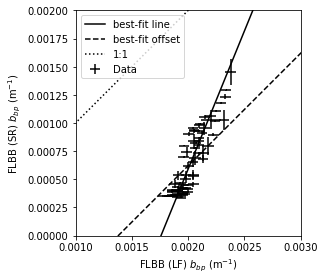

In [10]:
# plot results
xx = [0,2e-2]
plt.errorbar(x[iinds],y[iinds],xerr=dx[iinds],yerr=dy[iinds],ls='none',label='Data',clip_on=False,marker=',',color='k')
plt.plot(xx,np.polyval(fit_line.beta,xx),label='best-fit line',color='k')
plt.plot(xx,xx+fit_offset.beta,label='best-fit offset',color='k',ls='--')
plt.plot(xx,xx,label='1:1',color='k',ls=':')
plt.legend(loc=0)
plt.gca().set_aspect(1)

plt.ylim([0,2e-3])
plt.xlim([1e-3,3e-3])
plt.xlabel(xlabel+' $b_{bp}$ (m$^{-1}$)')
plt.ylabel(ylabel+' $b_{bp}$ (m$^{-1}$)');

plt.tight_layout()


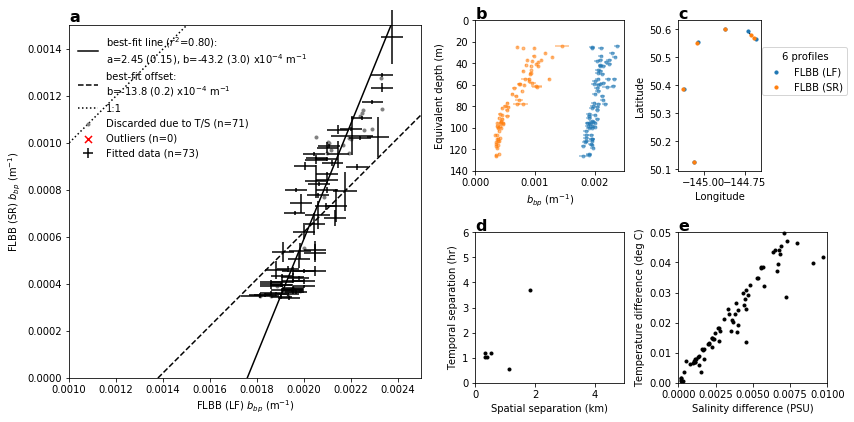

In [12]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
ax = [fig.add_subplot(gs[:, 0:2]),fig.add_subplot(gs[0,2]),fig.add_subplot(gs[0,3]),fig.add_subplot(gs[1,2]),fig.add_subplot(gs[1,3])]
xx = np.array([0,5e-3])
e = ax[0].errorbar(x[iinds],y[iinds],xerr=dx[iinds],yerr=dy[iinds],ls='none',
               label='Fitted data (n=%d)'%np.sum(iinds),clip_on=False,marker=',',color='k')
for b in e[2]:
    b.set_clip_on(False)
ax[0].plot(xx,np.polyval(fit_line.beta,xx),color='k',
           label='best-fit line ($r^2$=%.2f):\na=%.2f (%.2f), b=%+.1f (%.1f) x10$^{-4}$ m$^{-1}$'
           %(r**2,fit_line.beta[0],fit_line.sd_beta[0],fit_line.beta[1]*1e4,fit_line.sd_beta[1]*1e4))
ax[0].plot(xx,xx+fit_offset.beta,color='k',ls='--',label='best-fit offset:\nb=%+.1f (%.1f) x10$^{-4}$ m$^{-1}$'
           %(fit_offset.beta[0]*1e4,fit_offset.sd_beta[0]*1e4))
ax[0].plot(xx,xx,label='1:1',color='k',ls=':')
ax[0].scatter(x[~inds],y[~inds],c='0.5',zorder=-1,marker='.',label='Discarded due to T/S (n=%d)'%np.sum(~inds))
ax[0].scatter(x[outliers],y[outliers],c='r',zorder=-2,marker='x',s=50,label='Outliers (n=%d)'%np.sum(outliers))
e = ax[1].errorbar(x[iinds],np.concatenate(dep_interp1)[iinds],xerr=dx[iinds],
                   clip_on=False,ls='none',marker='.',alpha=0.5,label=xlabel)
for b in e[2]:
    b.set_clip_on(False)
e = ax[1].errorbar(y[iinds],np.concatenate(dep_interp1)[iinds],xerr=dy[iinds],
                   clip_on=False,ls='none',marker='.',alpha=0.5,label=ylabel)
for b in e[2]:
    b.set_clip_on(False)
ax[2].plot(np.vstack((data1[2],data2[2])),np.vstack((data1[1],data2[1])),c='k',lw=1,zorder=-1);
ax[2].scatter(data1[2],data1[1],label=xlabel,s=10)
ax[2].scatter(data2[2],data2[1],label=ylabel,s=10)
ax[3].scatter(dist,dtime*24,clip_on=False,marker='.',c='k')
ax[4].scatter(dsalt[iinds],dtemp[iinds],clip_on=False,marker='.',c='k')

ax[0].set_ylim([0,1.5e-3])
ax[0].set_xlim([1e-3,2.5e-3])
ax[0].set_xlabel(xlabel+' $b_{bp}$ (m$^{-1}$)')
ax[0].set_ylabel(ylabel+' $b_{bp}$ (m$^{-1}$)');
ax[0].legend(loc='upper left',frameon=False)
ax[0].set_aspect(1)
ax[1].set_xlim([0,2.5e-3])
ax[1].set_ylim([140,0])
ax[1].set_xlabel('$b_{bp}$ (m$^{-1}$)')
ax[1].set_ylabel('Equivalent depth (m)')
#ax[1].legend(loc=(1.02,0.5))
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Latitude')
xlim = ax[2].get_xlim()
ylim = ax[2].get_ylim()
ax[2].set_aspect(sw.dist(ylim,np.mean(xlim))[0]/sw.dist(np.mean(ylim),xlim)[0],anchor='W')
ax[2].legend(loc=(1.02,0.5),title='%d profiles'%len(data1[0]))
ax[3].set_xlim([0,5])
ax[3].set_ylim([0,6])
ax[3].set_xlabel('Spatial separation (km)')
ax[3].set_ylabel('Temporal separation (hr)');
ax[4].set_xlim([0,0.01])
ax[4].set_ylim([0,0.05])
ax[4].set_xlabel('Salinity difference (PSU)')
ax[4].set_ylabel('Temperature difference (deg C)');

for a,p in zip(ax,['a','b','c','d','e']):
    a.text(0,1.01,p,fontsize=16,fontweight='bold',transform=a.transAxes)

plt.tight_layout()
plt.savefig('bbp_FLBBSR_FLBBLF.png',dpi=300)